In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['text.usetex'] = False

from scipy.misc import derivative

'''I use the piecewise linear Ritz method to solve a second order  ordinary differential equation with a nonzero RHS
The d.e is of the form :  - d/dx(  k(x)dy/dx) + q(x)y = f(x).
The integration is performed on the interval a<=x<=b'''



#coefficient functions 
def k(x, k1 = 2,k2 = 1,k3 = 0):
    '''Defining the coefficient k in the d.e.'''
    return k1*np.sin(k2*x) + k3

def q(x, q1 = 2,q2 = 1,q3 = 0):
    '''Defining the coefficient q in the d.e.'''
    return q1*np.cos(q2*x) + q3


def p(x, p1 = 1,p2 = 1,p3 = 1):
    '''Defining the coefficient p in the d.e.'''
    return p1*np.sin(p2*x) + p3




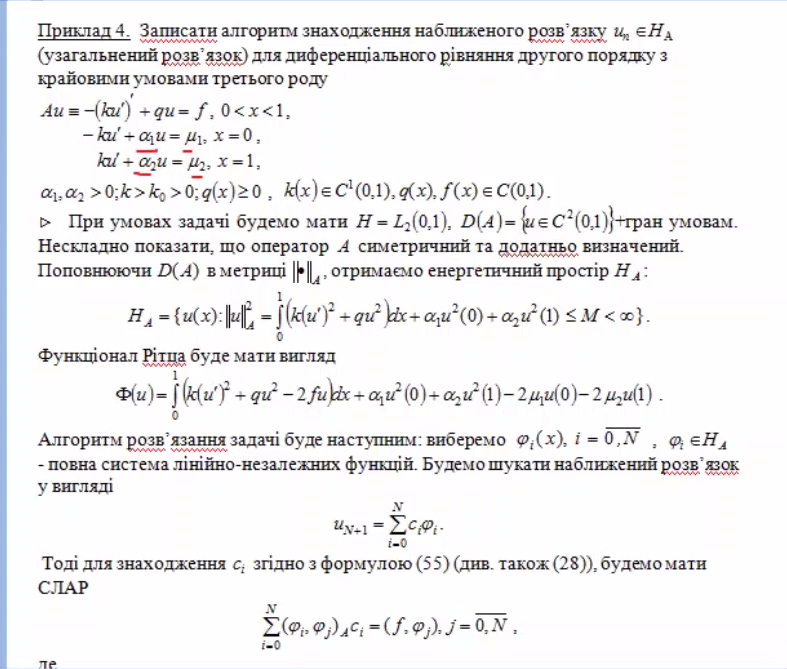

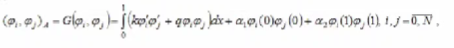

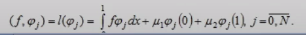

In [13]:
alpha1 = 10
alpha2 = 10

def find_params2(k_x, q_x, p_x, a1, a2, a, b, real):
    
    du = lambda a: (real(a+1/10000) - real(a))/(1/10000)
    f_x = lambda x: -(k_x(x+1/10000)*du(x+1/10000) - k_x(x)*du(x))/(1/10000) + q_x(x)*real(x)  + du(x)*p_x(x)



    mu1 = -du(a) * k_x(a) + a1*real(a)
    mu2 = du(a)* k_x(b) + a2*real(b)
    return f_x, mu1, mu2

def real(x, p1=1, p2=np.pi, p3=1):
    '''Defining the coefficient p in the d.e.'''
    return p1 * np.sin(p2 * x) + p3

a = 0
b = 1

rhs, mu1, mu2 = find_params2(k,q,lambda x: 0, alpha1, alpha2, a, b, real)

rhs2, mu12, mu22 = find_params2(k,q,p, alpha1, alpha2, a, b, real)

print(mu12, mu22)

A1_r =  (alpha2*mu1-alpha1*mu2)/(alpha2*(-k(a)+a*alpha1)-alpha1*(k(b)+b*alpha2))
print(A1_r)
B1_r =  (k(b)*A1_r+alpha2*b*A1_r-mu2)/(-alpha2)
print(B1_r)

A1_bub =  (alpha2*mu12-alpha1*mu22)/(alpha2*(-k(a)+a*alpha1)-alpha1*(k(b)+b*alpha2))
print(A1_bub )
B1_bub =  (k(b)*A1_bub+alpha2*b*A1_bub-mu22)/(-alpha2)
print(B1_bub)


10.0 15.287118041191892
0.4525502270697116
1.0000000000000002
0.4525502270697116
1.0000000000000002


In [14]:
A2_b = b + k(b)*(b-a)/(2*k(b)+alpha2*(b-a)) 

B2_b = a -k(a)*(b-a)/(2*k(a)+alpha1*(b-a))
print(A2_b, B2_b)

A2_r = b + k(b)*(b-a)/(2*k(b)+alpha2*(b-a)) 

B2_r= a -k(a)*(b-a)/(2*k(a)+alpha1*(b-a))

1.125913256262537 0.0


In [15]:
def A_U(k,p,q, u1x,a, b,x, n=10000):
    step = (b-a)/n
    
    du1 = lambda x: (u1x(x+step) - u1x(x)) / step
    
    duk1du1  = lambda x: (k(x+step) - k(x))/step * du1(x) + (du1(x+step) - du1(x))/step * k(x) 
    return  -duk1du1(x) + p(x)*du1(x) + q(x)*u1x(x)

In [16]:
def W_basis1(x,m, A2, B2,a=0,b=4):
    result = [(x-a)**2*(x-A2), (x-B2)*(b-x)**2]
    result.extend([((x-a)**(2))*(b-x)**i for i in range(2,m)])
    
    return np.array(result)


In [17]:

def ph1_dot_phi2_corr(k, q, a, b, alpha1, alpha2,m,basis, n = 1000):
    p = lambda x: 0
    step = (b-a)/(n-1)
    result = np.zeros((m**2, 1))
    for i in range(m):
        for j in  range(m):
            dbasisi = lambda x: (basis(x+step)[i] - basis(x,)[i])/step
            dbasisj = lambda x: (basis(x+step)[j] - basis(x,)[j])/step
            dkphi = lambda x: (k(x+step) * dbasisi(x+step) - k(x) * dbasisi(x))/step
            sumij = alpha1* basis(a)[i]* basis(a)[j] + alpha2* basis(b)[j] * basis(b)[i]
            sumij = 0 
            for l in range(n):
                
                #sumij += (-dkphi(l*step + a) +basis(l*step +a,m,a, b)[i] ) * basis(l*step +a,m,a, b)[j] *step
                #sumij += (k(a+l*step)*dbasisi(a+l*step)*dbasisj(a+l*step) + q(l*step+a)* 
                #          basis(l*step+a)[j] * basis(l*step+a)[i]) *step
                sumij += A_U(k,p,q, lambda x: basis(x)[i], a, b,(l*step+a)) * basis(l*step+a)[j] *step
            result[i*m+j] = sumij
    return result.reshape((m,m))



def f_dot_phij_corr(f, mu1, mu2,a,b,m,basis, n = 1000):
    result = np.zeros((m,1))
    step = (b-a)/(n-1)
    for j in range(m):
        sumij = mu1*basis(a)[j] + mu2*basis(b)[j]
        sumij = 0
        for i in range(n):
            sumij += f(a+i*step)*basis(a+i*step)[j]*step
        result[j,0] = sumij
    return result


def ph1_dot_phi2_corr_bub(k, q,p, a, b, alpha1, alpha2,m,basis, n = 1000):

    step = (b-a)/(n-1)
    result = np.zeros((m, m))
    for i in range(m):
        for j in  range(m):
            
            sumij = 0
            for l in range(n):
                
                sumij += A_U(k,p,q, lambda x: basis(x)[i], a, b,(l*step+a)) * basis(l*step+a)[j] *step
                
            
            result[j,i] = sumij
    return result



def f_dot_phij_corr_bub(f, mu1, mu2,a,b,m,basis, n = 1000):
    result = np.zeros((m,1))
    step = (b-a)/(n-1)
    for j in range(m):
        sumij = 0
        for i in range(n):
            sumij += f(a+i*step)*basis(a+i*step)[j]*step
        result[j,0] = sumij
    return result

In [18]:
def draw(k,p, q,f, mu1, mu2,a,b, alpha1, alpha2,m,basis, n = 10000):
    #RITZ
    #
    basis_b =  lambda x: basis(x,m, A2_b, B2_b,a,b)
    basis_r=   lambda x: basis(x,m, A2_r, B2_r,a,b)
    right = f_dot_phij_corr(lambda x: rhs(x)- A_U(k,lambda x: 0,q,lambda x: A1_r*x + B1_r,a,b,x) , mu1, mu2,a,b,m,basis_r, n )
    left =ph1_dot_phi2_corr(k,q, a, b, alpha1, alpha2, m,basis_r, n )
    answ = np.linalg.solve(left,right)
    
    
    right2 = f_dot_phij_corr_bub(lambda x: rhs2(x) - A_U(k,p,q,lambda x: A1_bub*x + B1_bub,a,b,x) , mu12, mu22,a,b,m,basis_b, n )
    left2 =ph1_dot_phi2_corr_bub(k,q,p, a, b, alpha1, alpha2, m, basis_b, n )
    answ2 = np.linalg.solve(left2,right2)
    
    X = np.linspace(a,b,1001)
    #Y = [(answ.reshape((1,-1)) @ W_basis(x,m)).reshape((1,-1))[0] + A1*x + B1  for x in X]
    Y = [(answ.reshape((1,-1)) @ basis_r(x)).reshape((1,-1))[0] + A1_r*x + B1_r  for x in X]
    Y2 = [(answ2.reshape((1,-1)) @ basis_b(x)).reshape((1,-1))[0] +  A1_bub*x + B1_bub  for x in X]
    
    n = 1001
    step = (b-a)/n
    err_ritz = np.sqrt(np.sum(np.array([(Y[l]-np.array([real(x) for x in X])[l])**2/(b-a)*step for l in range(n)])))
    print(f"Ritz error: {err_ritz}")
    
    err_bub = np.sqrt(np.sum(np.array([(Y2[l]-np.array([real(x) for x in X])[l])**2/(b-a)*step for l in range(n)])))
    print(f"Bubnove error: error: {err_bub}")
    
    
    #plt.plot(X, Y,X ,np.array([real(x) for x in X]),  X, Y2)
    plt.figure(figsize=(10, 6))
    
    plt.plot(X, Y, label="Ritz")
    plt.plot(X,np.array([real(x) for x in X]), color='red', label="Real")
    plt.plot(X, Y2 , label = 'Bubnova_g')
    
    plt.legend()


    # Display the plot
    plt.show()

Ritz error: 0.6212702613115816
Bubnove error: error: 0.47329473230434904


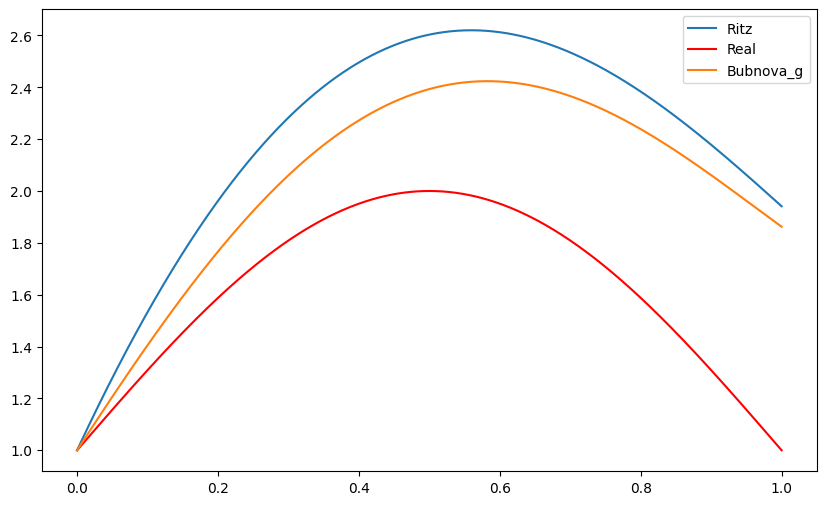

In [19]:
draw(k,p,q,rhs,mu1,mu2,a,b,alpha1, alpha2,3, W_basis1, 1000)

Ritz error: 0.6370052557568929
Bubnove error: error: 0.4778073545202051


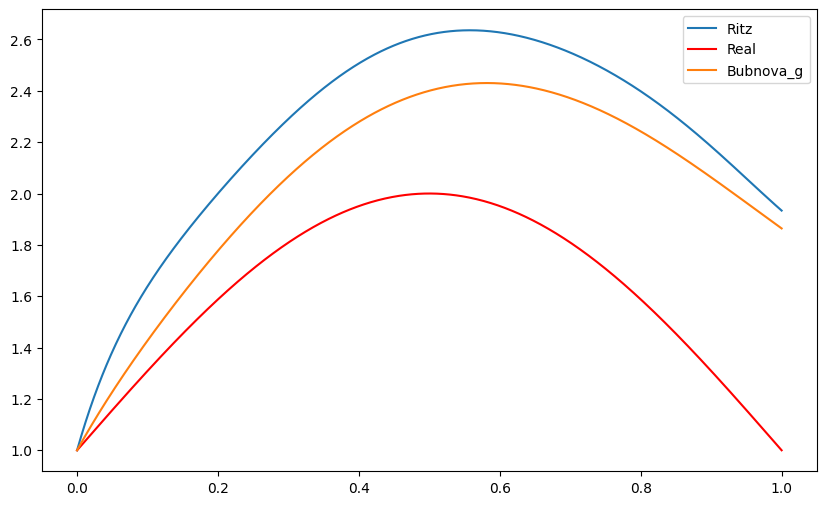

In [20]:
draw(k,p,q,rhs,mu1,mu2,a,b,alpha1, alpha2,7, W_basis1, 1000)

Ritz error: 0.6474849364503906
Bubnove error: error: 0.4796525972306218


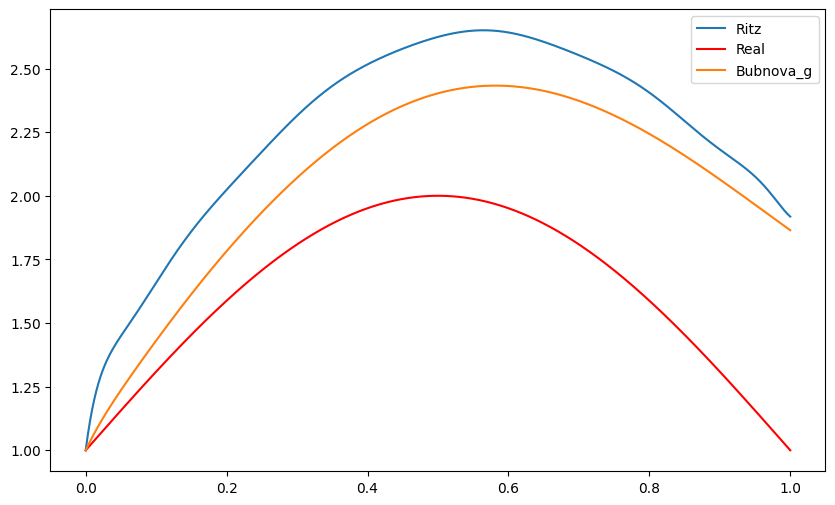

In [21]:
draw(k,p,q,rhs,mu1,mu2,a,b,alpha1, alpha2,12, W_basis1, 1000)

Ritz error: 0.63590801702437
Bubnove error: error: 0.480548000626878


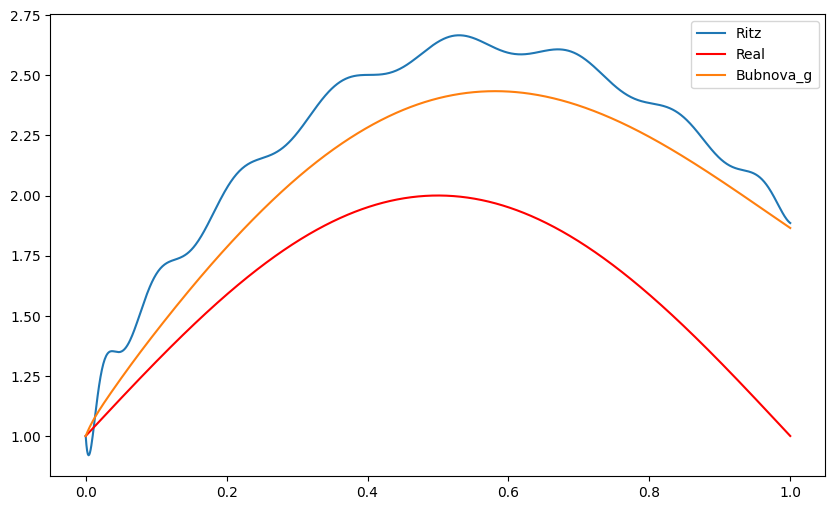

In [22]:
draw(k,p,q,rhs,mu1,mu2,a,b,alpha1, alpha2,22, W_basis1, 500)